In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error

In [2]:
class Layer:
    def __init__(self, input_size, output_size, activation_func):
            # Initialize weight matrixes with random starting values shaped input x output size
        if activation_func == "relu":
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size) #He init for relu 
            #https://medium.com/@piyushkashyap045/mastering-weight-initialization-in-neural-networks-a-beginners-guide-6066403140e9
        else: #assuming sigmoid or linear
            self.weights=np.random.randn(input_size, output_size) *0.01
        #biases are in the shape of output size to match next layer
        self.biases = np.random.randn(output_size) *0.01
        self.activation = activation_func
        #storing values for future backprop
        self.values=None
        self.z=None #layer after weight and bias multiplication
        self.a=None #layer after activation


In [3]:
class NeuralNetwork:
    def __init__(self, layer_list, activation_list):
        assert len(activation_list) == len(layer_list) - 1, \
            f"Mismatch: {len(activation_list)} activations for {len(layer_list)-1} needed layers"
        #making sure activation list and layer size match
        
        #Layer setup using Layer class
        self.layers = []
        self.layer_list=layer_list
        for l in range(len(self.layer_list)-1): #last item is output layer
            one_layer=Layer(self.layer_list[l],self.layer_list[l+1],activation_list[l]) #input_size=l index layer list, output_size=next index layer list, activation_func = lth from activation list
            self.layers.append(one_layer)
        self.loops=None
        self.errors=None
    #testing to see if layer buildup is correct
    def show_layers(self):
        for l in range(len(self.layers)):
            print(f"Layer {l+1} weights {self.layers[l].weights} biases {self.layers[l].biases} activation {self.layers[l].activation}")
    
    #Forward setup and method            
    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1/(1+np.exp(-z)) 

    @staticmethod
    def relu(z):
        return np.maximum(0, z)
    
    
    def forward(self, inputs):
        current_output = inputs
        self.last_input=inputs
        #work through every layer
        for layer in self.layers:
            #storing starting values
            layer.input = current_output
            z = np.dot(current_output, layer.weights) + layer.biases
            #storing after matrix and bias
            layer.z = z #Output value before activation
            
            #Conditionals for activation type
            if layer.activation == "sigmoid":
                layer.a = self.sigmoid(layer.z)
            elif layer.activation == "relu":
                layer.a = self.relu(layer.z)                
            else: #linear activation
                layer.a=layer.z
            #debug check for exploding or imploding variables
            if np.isnan(layer.z).any() or np.isinf(layer.z).any():
                print(f"NaN or Inf detected in z at layer with activation {layer.activation}")
                break
            if np.isnan(layer.a).any() or np.isinf(layer.a).any():
                print(f"NaN or Inf detected in a at layer with activation {layer.activation}")
                break

            
            #updating output variable with activated layer values for next iteration
            current_output=layer.a
 
        return current_output #y_pred if last layer
    
    #setting up backpropagation
    @staticmethod    
    def sigmoid_derivative(z):
        z=np.clip(z,-500,500) #trying to limit variable size to prevent explosion or vanishing
        s = 1/(1+np.exp(-z))
        return s * (1 - s) 
    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(np.float32) #"write derivative of the relu function"    
    
    def loss_deriv(self, y_pred, y_true):
        #i think i could remove the 2* since it doesnt effect the direction of the derivative. But I'd need bigger learning rate
        # ensuring matching shapes for regression otherwise things explode too often
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)

        return 2 * (y_pred - y_true) / y_true.shape[0]  # Normalized MSE gradient    
    
    def backward(self,y_pred, y_true, lr=0.001):
        #derivative of activation with respect to loss dL/dA
        dA = self.loss_deriv(y_pred, y_true)
        
        #walk backwards through layers
        for l in reversed(range(len(self.layers))):
            layer=self.layers[l]
            
            #Conditionals for derivatives of activation functions
            #dZ derivaive of loss with respect to linear output
            if layer.activation == "sigmoid":
                dZ=dA*self.sigmoid_derivative(layer.z)
            elif layer.activation == "relu": #relu derivative
                dZ=dA*self.relu_derivative(layer.z)
            else: #linear activation
                dZ=dA # d of f(z) = z is 1   
            
            #debug check for dZ
            if np.isnan(dZ).any() or np.isinf(dZ).any():
                print(f"NaN or Inf in dZ at layer {l}")
                break

            #Chain rule
            dW=np.dot(layer.input.T,dZ)
            db=np.sum(dZ, axis=0)  #dL/db= dL/dZ*dZ/db == dZ*1 == sum of dZ of all samples
            
            #debug check layer
            if np.isnan(layer.input).any():
                print(f"NaNs in input to layer {l}")
                break
  
            if l != 0: #go backwards by updating dA to fit into activation derivatives of previous layers
                dA = np.dot(dZ, layer.weights.T)
            
            # Gradient descent step
            layer.weights -= lr * dW
            layer.biases -= lr * db
    
    def mse(self,y_pred, y_true):
        return np.mean(np.square(y_true - y_pred))     

    def train(self, X_train, y_train, loops=100, lr=0.001, lr_decay=False, batch=32):
        error_list=[]
        for i in range(loops):
            #conditional for Stochastic batching
            if batch != 0:
                indices= np.random.choice(X_train.shape[0], batch,replace=False)
                x_batch = X_train[indices]
                y_batch = y_train[indices]
            else:
                x_batch=X_train
                y_batch=y_train
    
            y_pred=self.forward(x_batch)
        
            #TODO Här ska vi ha MSE lista
            one_error=self.mse(y_pred,y_batch)
            error_list.append(one_error)
        
            #conditional for decaying learning rate
            if i % (loops/5) == 0 and i !=0 and lr_decay==True:
                lr=lr*0.95
            #mse update    
            if i % (loops/10) == 0 and i !=0:
                    print("MSE is", self.mse(y_pred,y_batch))
                    
            self.backward(y_pred,y_batch, lr=lr)
        self.errors=error_list
        self.loops=loops
        return error_list[-1] #last error for comparing to test data
    
    #prediction time!
    def predict(self,X_test, y_test):
        pred=self.forward(X_test) #1 round of forward to apply latest weights and biases
        acc = np.mean((pred - y_test) ** 2)   # MSE for regression

        return pred, acc
    
    # def last_error(self):
    #     return self.error_list
    
    def performance_graph(self):
        x_line=[x for x in range(self.loops)]

        plt.plot(x_line, self.errors, label="Error rate")
        plt.title(f"Error rate over {self.loops} loops")
        plt.xlabel(f"N loops")
        plt.ylabel("Error")
        plt.legend()
        plt.show()

                          

MSE is 217.27136151757801
MSE is 89.14727067757633
MSE is 40.731605014208604
MSE is 23.16738005030582
MSE is 14.96435528044944
MSE is 10.5231127226773
MSE is 7.858585640146758
MSE is 6.1110269615806985
MSE is 4.882629440927988
3.985740426515611 4.5613594452076835


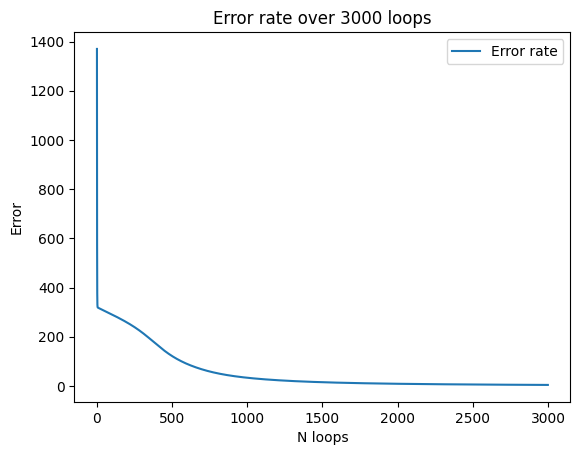

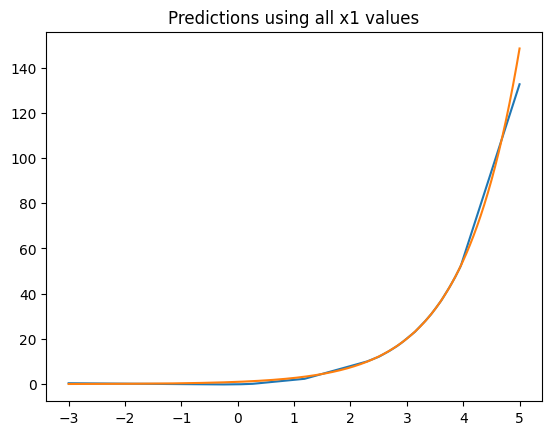

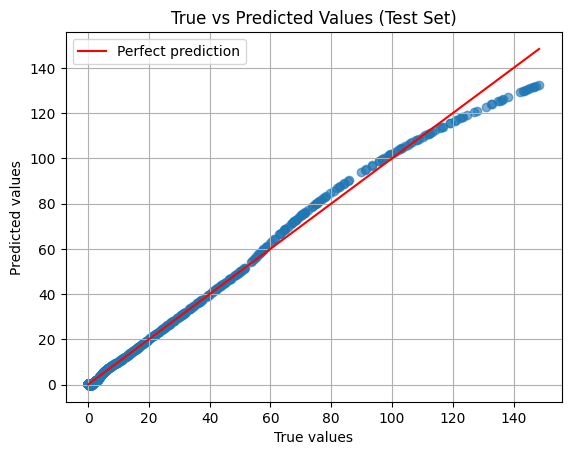

In [ ]:
x1 = np.linspace(-3, 5, 3000).reshape(-1, 1)

f1_y=np.exp(x1)

f1X_train, f1X_test, f1y_train, f1y_test = train_test_split(x1, f1_y, test_size=0.33, random_state=42)

f1_node_list=[1,64,1]
f1_activation_list=["relu","linear"]
NNf1=NeuralNetwork(f1_node_list,f1_activation_list)
f1_last_error=NNf1.train(f1X_train, f1y_train, loops=3000, lr=0.001, lr_decay=False, batch=0)
f1_pred, f1_acc=NNf1.predict(f1X_test,f1y_test)
print(f1_last_error,f1_acc)
NNf1.performance_graph()

f1_pred_all, f1_acc=NNf1.predict(x1,f1_y)
plt.plot(x1, f1_pred_all, label = "Predicted values")
plt.plot(x1, f1_y, label="True values")
plt.title("Predictions using all x1 values")
plt.show()

plt.scatter(f1y_test, f1_pred, alpha=0.6)
plt.plot([min(f1y_test), max(f1y_test)], [min(f1y_test), max(f1y_test)], color="red", label='Perfect prediction')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [5]:


f1_errors_df=pd.DataFrame({"Data": ["Training", "Test"],
                        "Error": [f1_last_error,f1_acc]}).style.set_caption("F1 errors")
f1_errors_df

,Data,Error
0,Training,3.985740
1,Test,4.173971


MSE is 0.021372124010805092
MSE is 0.0014876760999065369
MSE is 0.0008691477139000351
MSE is 0.00020519636277992914
MSE is 0.00014803654473765143
MSE is 8.779332780554469e-05
MSE is 5.9129201034466495e-05
MSE is 6.564555459033737e-05
MSE is 8.390057120137253e-05
5.443165655615817e-05


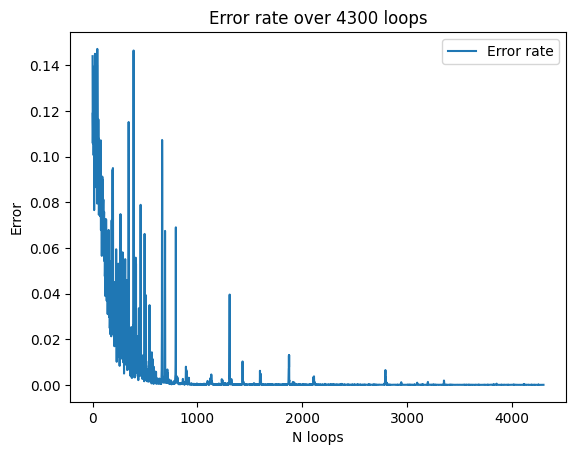

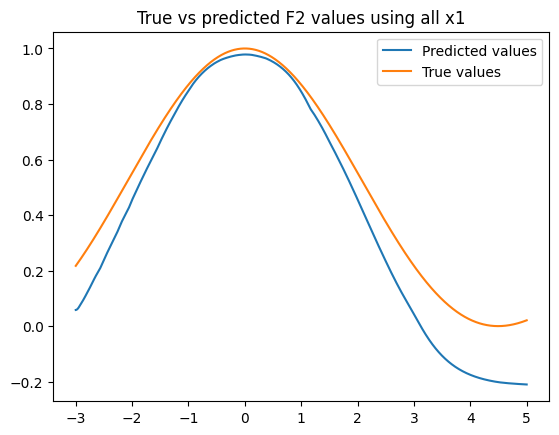

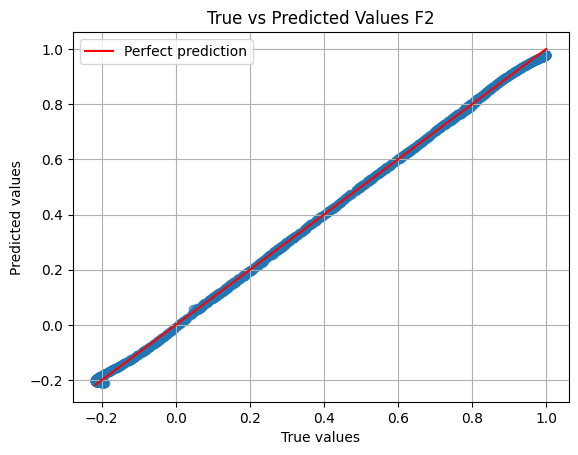

In [6]:
#scaling to increase LR and decreasing risk of exploding/vanishing gradients in fZ
x1 = np.linspace(-3, 5, 3000).reshape(-1, 1)
f2_y=np.sin(x1)/x1
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


x1=X_scaler.fit_transform(x1)
f2_y=y_scaler.fit_transform(f2_y)

f2X_train, f2X_test, f2y_train, f2y_test = train_test_split(x1, f2_y, test_size=0.33, random_state=42)


f2_node_list = [1, 64, 64, 32, 32,32,32, 1]  # Multiple 32-node layers
f2_activation_list = ["relu", "relu", "relu", "relu", "relu","relu","sigmoid"]
NNf2_s=NeuralNetwork(f2_node_list,f2_activation_list)


f2_errors=NNf2_s.train(f2X_train, f2y_train, loops=4300, lr=0.16, lr_decay=True,)
f2_pred, f2_acc=NNf2_s.predict(f2X_test,f2y_test)

#all predictions for presentation graph
f2_pred_all, f2_acc_all=NNf2_s.predict(x1,f2_y)

#scaling back
f2_pred = y_scaler.inverse_transform(f2_pred)
f2y_test = y_scaler.inverse_transform(f2y_test)
f2_pred_all=y_scaler.inverse_transform(f2_pred_all)
x1 = X_scaler.inverse_transform(x1)



final_mse = np.mean((f2_pred - f2y_test) ** 2)
print(f2_acc)
NNf2_s.performance_graph()


plt.plot(x1, f2_pred_all, label = "Predicted values")
plt.plot(x1, f2_y, label="True values")
plt.legend()
plt.title("True vs predicted F2 values using all x1")
plt.show()

plt.scatter(f2y_test, f2_pred, alpha=0.6)
plt.plot([min(f2y_test), max(f2y_test)], [min(f2y_test), max(f2y_test)], color="red", label='Perfect prediction')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted Values F2")
plt.legend()
plt.grid(True)
plt.show()

In [7]:


f2_errors_df=pd.DataFrame({"Data": ["Training", "Test"],
                        "Error": [f2_errors,f2_acc]}).style.set_caption("F2 errors")
f2_errors_df

,Data,Error
0,Training,0.000061
1,Test,0.000054


MSE is 0.05976968571986554
MSE is 0.0644111421903204
MSE is 0.06871027064412091
MSE is 0.05992543512271983
MSE is 0.07447862704263167
MSE is 0.06283289950614845
MSE is 0.07741439835005855
MSE is 0.08111076348937407
MSE is 0.08921693349386488
Final MSE: 0.26161300629488526


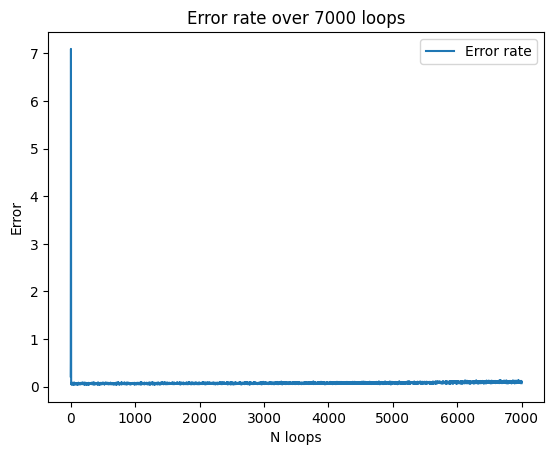

In [77]:
# Data prep
X1, X2 = np.meshgrid(np.linspace(-3, 5, 100), np.linspace(-3, 5, 100))
f3X_features = np.vstack([X1.ravel(), X2.ravel()]).T
f3_y = (np.sin(X1) + np.cos(X2)).ravel()
f3X_train, f3X_test, f3y_train, f3y_test = train_test_split(f3X_features, f3_y, test_size=0.33)

# Scaling otherwise things explode or vanish
X_scaler = MinMaxScaler()
f3X_train_scaled = X_scaler.fit_transform(f3X_train)
f3X_test_scaled = X_scaler.transform(f3X_test)
f3X_features_scaled = X_scaler.transform(f3X_features)
#I even had do scale and unscale y. Dunno if i made a misstake while building the network
y_scaler = MinMaxScaler()
f3y_train_scaled = y_scaler.fit_transform(f3y_train.reshape(-1, 1)).ravel()
f3y_test_scaled = y_scaler.transform(f3y_test.reshape(-1, 1)).ravel()



f3_node_list = [2, 48,32,24, 1]
f3_activation_list  = ["relu","sigmoid", "sigmoid","linear"]
## This is the superfitting version of the NN that almost makes a perfect copy of the function but takes more time and is maginally better in absolute error
# f3_node_list = [2, 96, 96, 64, 48, 32, 24, 1] #many layers to catch all oscilations. Start big for overall pattern then go down for details.
# f3_activation_list = ["relu", "sigmoid", "relu", "sigmoid", "relu", "sigmoid", "linear"]


NNf3 = NeuralNetwork(f3_node_list, f3_activation_list)
# Train
f3_errors= NNf3.train(f3X_train_scaled, f3y_train_scaled, loops=7000, lr=0.2, batch=64)

# Predict (unscale for final MSE)
f3_pred_scaled, unscaled_mse = NNf3.predict(f3X_test_scaled, f3y_test_scaled)

## pred all for graphing
f3_pred_all_scaled, f3_acc_all=NNf3.predict(f3X_features_scaled,f3_y)
# CORRECTION #2: Inverse transform the predictions for visualization
f3_pred_all = y_scaler.inverse_transform(f3_pred_all_scaled.reshape(-1, 1)).ravel()

##
f3_pred = y_scaler.inverse_transform(f3_pred_scaled.reshape(-1, 1))
f3_acc = np.mean((f3_pred - f3y_test.reshape(-1, 1)) ** 2)
print(f"Final MSE: {f3_acc}")
NNf3.performance_graph()




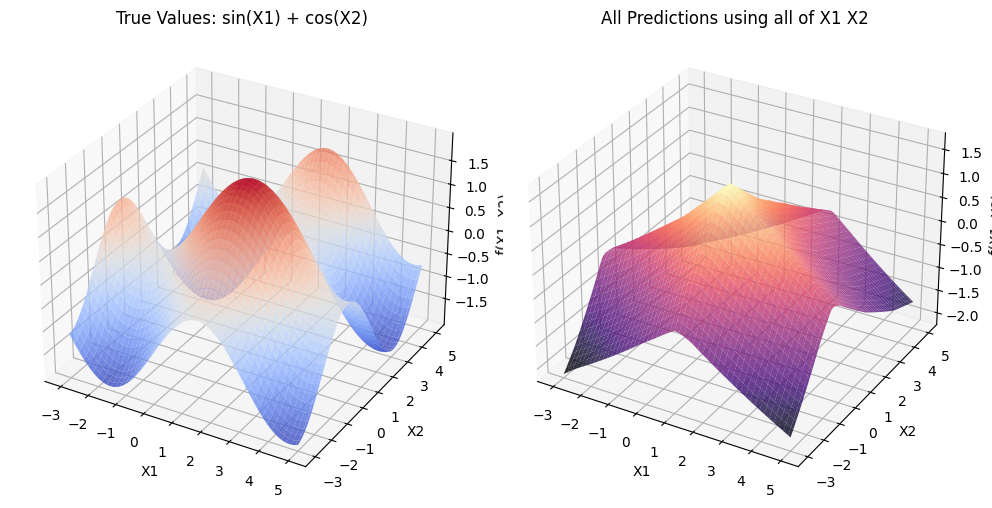

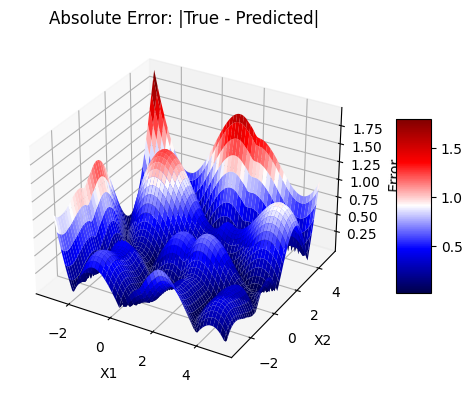

In [78]:


# Create figure with two subplots
fig = plt.figure(figsize=(10, 5))

# First subplot - True values
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X1, X2, np.reshape(f3_y, X1.shape), cmap="coolwarm",
                       linewidth=0, antialiased=True, alpha=0.8)
ax1.set_title('True Values: sin(X1) + cos(X2)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('f(X1, X2)')

# Second subplot - Predicted values
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X1, X2, np.reshape(f3_pred_all, X1.shape), cmap="magma",
                       linewidth=0, antialiased=True, alpha=0.8)
ax2.set_title('All Predictions using all of X1 X2')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('f(X1, X2)')
plt.tight_layout()
plt.show()

# Also create a difference plot to see errors
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')
diff = np.abs(np.reshape(f3_y, X1.shape) - np.reshape(f3_pred_all, X1.shape))
surf = ax.plot_surface(X1, X2, diff, cmap="seismic",
                     linewidth=0, antialiased=True)
ax.set_title('Absolute Error: |True - Predicted|')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Error')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

In [79]:


f3_errors_df=pd.DataFrame({"Data": ["Training", "Test"],
                        "Error": [f3_errors,f3_acc]}).style.set_caption("F3 errors")
f3_errors_df

,Data,Error
0,Training,0.070771
1,Test,0.261613


# MNIST CHALLENGE

Sorry for the patchy code. I tried making it able to handle all kinds of inputs and had some trouble with classification over regression

In [11]:
class Layer2:
    def __init__(self, input_size, output_size, activation_func):
        
            # Initialize weight matrixes with random starting values shaped input x output size
        if activation_func == "relu":
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size) #He init for relu
        elif activation_func== "softmax":
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(1. / input_size) #xavier for softmax
        ##https://medium.com/@piyushkashyap045/mastering-weight-initialization-in-neural-networks-a-beginners-guide-6066403140e9
        else:
            self.weights=np.random.randn(input_size, output_size) *0.01
        #biases are in the shape of output size to match next layer
        self.biases = np.random.randn(output_size) *0.01
        self.activation = activation_func
        #storing values for future backprop
        self.values=None
        self.z=None #layer after weight and bias multiplication
        self.a=None #layer after activation


In [ ]:
class NeuralNetwork2:
    def __init__(self, layer_list, activation_list, classification=False):
        self.classification=classification
        assert len(activation_list) == len(layer_list) - 1, \
            f"Mismatch: {len(activation_list)} activations for {len(layer_list)-1} needed layers"
        #making sure activation list and layer size match
        
        #Layer setup using Layer class
        self.layers = []
        self.layer_list=layer_list
        for l in range(len(self.layer_list)-1): #last item is output layer
            one_layer=Layer(self.layer_list[l],self.layer_list[l+1],activation_list[l]) #input=l index layer list, output=next index layer list, activation = lth from activation

            self.layers.append(one_layer)
     #testing to see if layer buildup is correct
    def show_layers(self):
        for l in range(len(self.layers)):
            print(f"Layer {l+1} weights {self.layers[l].weights} biases {self.layers[l].biases} activation {self.layers[l].activation}")

    #Forward setup and method            
    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1/(1+np.exp(-z)) 
    @staticmethod
    def relu(z):
        return np.maximum(0, z)
    #Added softmax for classification. Thanks to StatQuest for cluing me in on the term
    #exponentiate every output value
    #divide that value by the sum of all exponentiated values
    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # subtract max for stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
              
    def forward(self, inputs):
        current_output = inputs
        self.last_input=inputs
        #work through every layer
        for layer in self.layers:
            #storing starting values
            layer.input = current_output
            z = np.dot(current_output, layer.weights) + layer.biases
            #storing after matrix and bias
            layer.z = z #Output value before activation
            
            #Conditionals for activation type and storing
            if layer.activation == "sigmoid":
                layer.a = self.sigmoid(layer.z)
            elif layer.activation == "relu":
                layer.a = self.relu(layer.z)
            elif layer.activation == "softmax":
                layer.a=self.softmax(layer.z)
            else: #linear activation
                layer.a=layer.z
            #debug check for exploding or imploding variables
            if np.isnan(layer.z).any() or np.isinf(layer.z).any():
                print(f"NaN or Inf detected in z at layer with activation {layer.activation}")
            if np.isnan(layer.a).any() or np.isinf(layer.a).any():
                print(f"NaN or Inf detected in a at layer with activation {layer.activation}")

            
            #updating output variable with activated layer values for next iteration
            current_output=layer.a
 
        return current_output #y_pred if last layer
     
    #setting up backpropagation
    @staticmethod    
    def sigmoid_derivative(z): 
        z=np.clip(z,-500,500) #trying to limit variable size to prevent explosion or vanishing
        s = 1/(1+np.exp(-z))
        return s * (1 - s)
    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(np.float32)
 
    def loss_deriv(self, y_pred, y_true):
         #i think i could remove the 2* since it doesnt effect the direction of the derivative. But I'd need bigger learning rate
        if self.classification:
            # y_true is one-hot encoded if classification task OHC=categories into numbers
            if y_true.ndim == 1:
                y_true = np.eye(y_pred.shape[1])[y_true]
            return (y_pred - y_true)  #dL/dz= Cross-entropy gradient @ softmax gradient simplified

        # ensuring matching shapes for regression otherwise things explode
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)

        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)

        return 2 * (y_pred - y_true) / y_true.shape[0]  # Normalized MSE gradient    
    def backward(self,y_pred, y_true, lr=0.001, loss="mse"):
        if self.classification:
            if y_true.ndim == 1:  # Convert to one-hot encoding if necessary
                y_true = np.eye(y_pred.shape[1])[y_true]
        
        if loss=="cross entropy":
            y_true = np.eye(y_pred.shape[1])[y_true] #num_classes x num_classes identity matrix for OHE

        #derivative of output loss
        if loss == "cross_entropy": #redundat i know but it felt good to keep this in
            dA = self.loss_deriv(y_pred, y_true)
        else:
            dA = self.loss_deriv(y_pred, y_true)
            
            
        #walk backwards through layer
        for l in reversed(range(len(self.layers))):
            layer=self.layers[l]
            
            #Derivatives of activation functions
            if layer.activation == "sigmoid":
                dZ=dA*self.sigmoid_derivative(layer.z)
            elif layer.activation == "relu":
                dZ=dA*self.relu_derivative(layer.z)
            elif layer.activation == "softmax":
                if y_true.ndim == 1 or y_true.shape[1] == 1:  # y_true is a vector of class indices
                    y_true = np.eye(y_pred.shape[1])[y_true.astype(int).flatten()]
                dZ = y_pred - y_true #Both dZ and dA is y_pred y_true when doing softmax+cross entropy!!!
            else: #linear activation
                dZ=dA # d of f(z) = z is 1   
            if np.isnan(dZ).any() or np.isinf(dZ).any():
                print(f"NaN or Inf in dZ at layer {l}")

            
            #Chain rule
            dW=np.dot(layer.input.T,dZ)
            db=np.sum(dZ, axis=0)
            
            #debugx1 = np.linspace(-3, 5, 500).reshape(-1, 1)


            if np.isnan(layer.input).any():
                print(f"NaNs in input to layer {l}")
            
            if np.isnan(dZ).any():
                print(f"NaNs in dZ at layer {l}")
                print("z sample:", layer.z[:5])
                
            #debug end    
            if l != 0: #go backwards by updating dA to fit into activation derivatives of previous layers
                dA = np.dot(dZ, layer.weights.T)
            
            # Gradient descent step
            layer.weights -= lr * dW
            layer.biases -= lr * db
            
 
    def mse(self,y_pred, y_true):
        if self.classification==True:
            if y_true.ndim == 1:  # Convert to one-hot encoding if y_true is not one-hot encoded    
                y_true = np.eye(y_pred.shape[1])[y_true]  
        # Reshape only if it's a regression task and 1D input
        if not self.classification and y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        if not self.classification and y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)
        return np.mean(np.square(y_true - y_pred))     
        

    def cross_entropy_loss(self, y_pred, y_true):
        # One-hot encode if needed
        if y_true.ndim == 1:
            y_true = np.eye(y_pred.shape[1])[y_true]
        # Clip to avoid log(0)
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
                    
    def train(self, X_train, y_train, loops=100, lr=0.001, loss="mse", lr_decay=False, batch=32):
        error_list=[]
        for i in range(loops):
            #conditional for Stochastic batching            
            if batch != 0:
                indices= np.random.choice(X_train.shape[0], batch,replace=False)
                x_batch = X_train[indices]
                y_batch = y_train[indices]
            else:
                x_batch=X_train
                y_batch=y_train
    
            y_pred=self.forward(x_batch)
            
            #conditionals for loss value
            if self.classification and loss=="cross entropy":
                loss_val = self.cross_entropy_loss(y_pred, y_batch)
            else:
                loss_val=self.mse(y_pred,y_batch)     
            error_list.append(loss_val)       
            #conditional for decaying learning rate            
            if i % (loops/5) == 0 and i !=0 and lr_decay==True:
                lr=lr*0.95
            #mse update with classification conditional                    
            if i % (loops/10) == 0 and i !=0:
                if self.classification and loss=="cross entropy":
                    print("Average loss at round", i, np.round(np.mean(error_list[-int(loops / 10):]),4))
                else:
                    print("MSE at round",i, np.round(loss_val,5))
                    
            self.backward(y_pred,y_batch, lr=lr)
        self.errors=error_list
        self.loops=loops
        
        if self.classification:
            final_pred = self.forward(X_train)
            pred_classes = np.argmax(final_pred, axis=1)
            train_accuracy = np.mean(pred_classes == y_train)  # Convert to percentage
            print("classification acc")
            return train_accuracy
        else:
            if batch != 0:
                last_10_percent = int(len(error_list) * 0.1)
                return np.mean(error_list[-last_10_percent:])
            else:
                return error_list[-1]  # last error for comparing to test data
    #prediction time!
    def predict(self,X_test, y_test):
        pred=self.forward(X_test) #1 round of forward to apply latest weights and biases
        
        if self.classification:
                pred=np.argmax(pred, axis=1) #1 for the most likely guess 
                acc = np.mean(pred == y_test) 
        else:
            acc = np.mean((pred - y_test) ** 2)   # MSE for regression

        return pred, acc
        
    def performance_graph(self):
        x_line=[x for x in range(self.loops)]

        plt.plot(x_line, self.errors, label="Error rate")
        plt.title(f"Error rate over {self.loops} loops")
        plt.xlabel(f"N loops")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
                            

In [80]:

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


scaler = MinMaxScaler()  
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Average loss at round 500 0.4983
Average loss at round 1000 0.1608
Average loss at round 1500 0.1135
Average loss at round 2000 0.0952
Average loss at round 2500 0.0805
Average loss at round 3000 0.0652
Average loss at round 3500 0.0577
Average loss at round 4000 0.0512
Average loss at round 4500 0.0408
classification acc
Test accuaricy % 97.13000000000001
Train accuaricy % 98.97


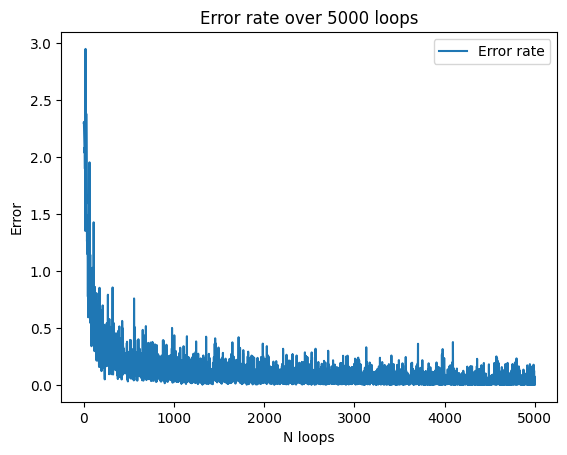

In [124]:
node_list=[]

node_list=[784,128,64,32,10]

activation_list=["relu", "relu","relu", "softmax"]

mnistNN=NeuralNetwork2(node_list, activation_list,classification=True)


mnist_error=mnistNN.train(X_train, y_train, loops=5000,lr=0.0078, loss="cross entropy", lr_decay=True, batch=64)
preds, mnist_acc=mnistNN.predict(X_test, y_test)

print("Test accuaricy %", np.round(mnist_acc,4)*100)
print("Train accuaricy %", np.round(mnist_error,4)*100)
mnistNN.performance_graph()

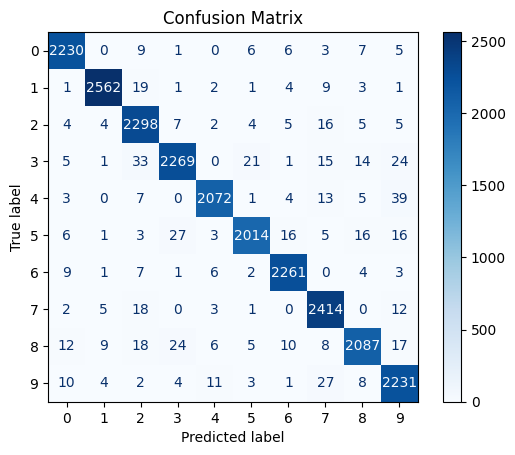

In [125]:

# y_true and y_pred should both be 1D arrays of class labels (e.g. integers 0-9)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [99]:

mnist_errors_df=pd.DataFrame({"Data": ["Training", "Test"],
                        "Error": [mnist_error, mnist_acc]}).style.set_caption("Mnist errors")
mnist_errors_df

,Data,Error
0,Training,0.970789
1,Test,0.958918


In [17]:

california_housing = fetch_california_housing()


X = california_housing.data 
y = california_housing.target
xscaler = StandardScaler()
yscaler = StandardScaler()
X=xscaler.fit_transform(X)
y=yscaler.fit_transform(y.reshape(-1,1))


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)


MSE at round 200 0.35231
MSE at round 400 0.33147
MSE at round 600 0.3185
MSE at round 800 0.309
MSE at round 1000 0.3016
MSE at round 1200 0.29567
MSE at round 1400 0.29081
MSE at round 1600 0.28673
MSE at round 1800 0.28318
Final MSE: 0.39153414820511245


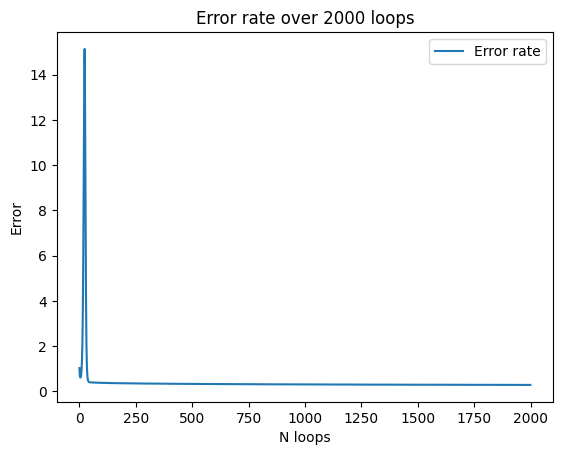

In [18]:
cali_nodes=[X.shape[1],124,1]
cali_activation=["relu","Linear"]
houseNN=NeuralNetwork2(cali_nodes, cali_activation,classification=False)
houseNN.train(X_train, y_train, loops=2000, lr=0.02, lr_decay=False, batch=0)
preds, acc=houseNN.predict(X_test, y_test)

preds = yscaler.inverse_transform(preds.reshape(-1, 1))
y_test = yscaler.inverse_transform(y_test.reshape(-1, 1))
final_mse = np.mean((preds - y_test) ** 2)
print(f"Final MSE: {final_mse}")
houseNN.performance_graph()

Grabbing MAE to compare to linear regression lab. Slightly better than polynomial regressions! But takes more time.

In [19]:


mean_absolute_error(preds,y_test)

0.4467701261320694